In [1]:
from collections import defaultdict, OrderedDict
from lxml import etree
from discoursegraphs import t
from discoursegraphs.readwrite.rst.rs3 import RSTTree, dt, extract_relationtypes, get_rs3_data
from discoursegraphs.readwrite.tree import get_position
from rstviewer import embed_rs3_image, embed_rs3str_image

In [2]:
RS3_EXAMPLE_FILE = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-1818.rs3'

# Testing

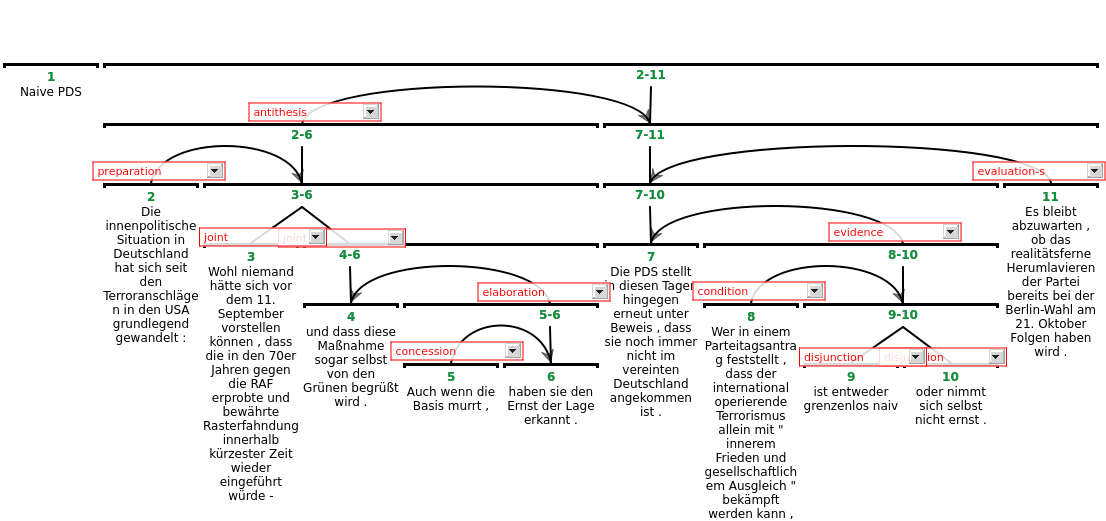

In [58]:
embed_rs3_image(RS3_EXAMPLE_FILE)

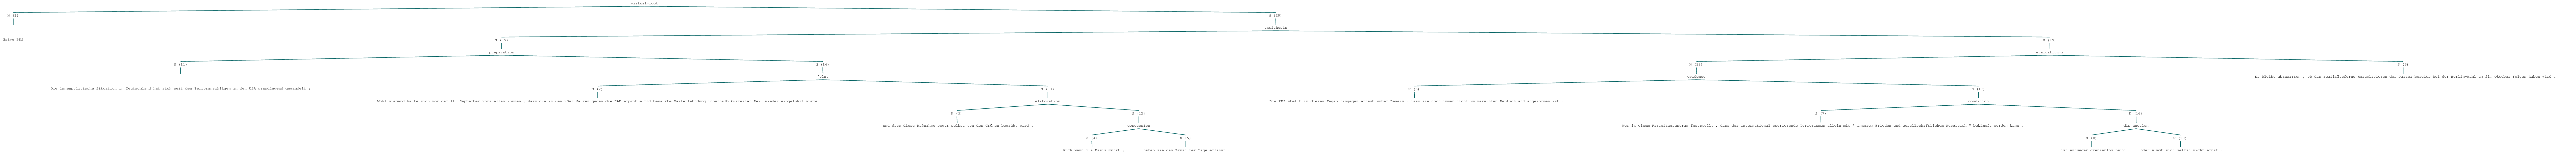

In [3]:
RSTTree(RS3_EXAMPLE_FILE)

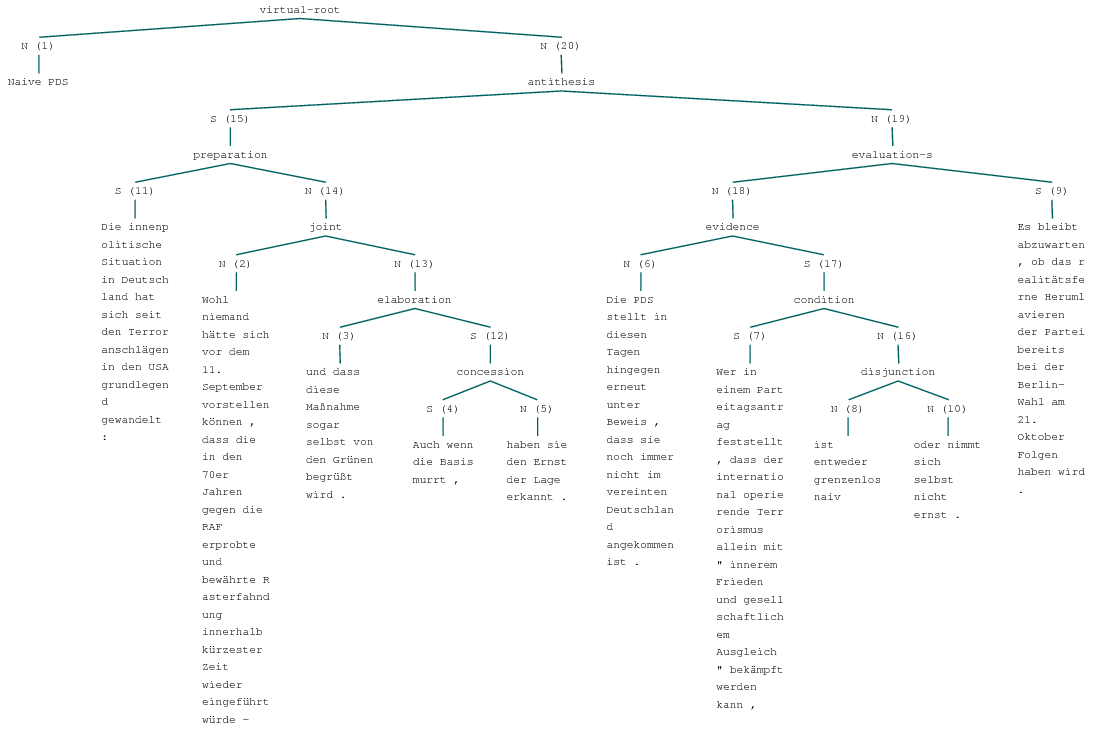

In [4]:
RSTTree(RS3_EXAMPLE_FILE, word_wrap=10)

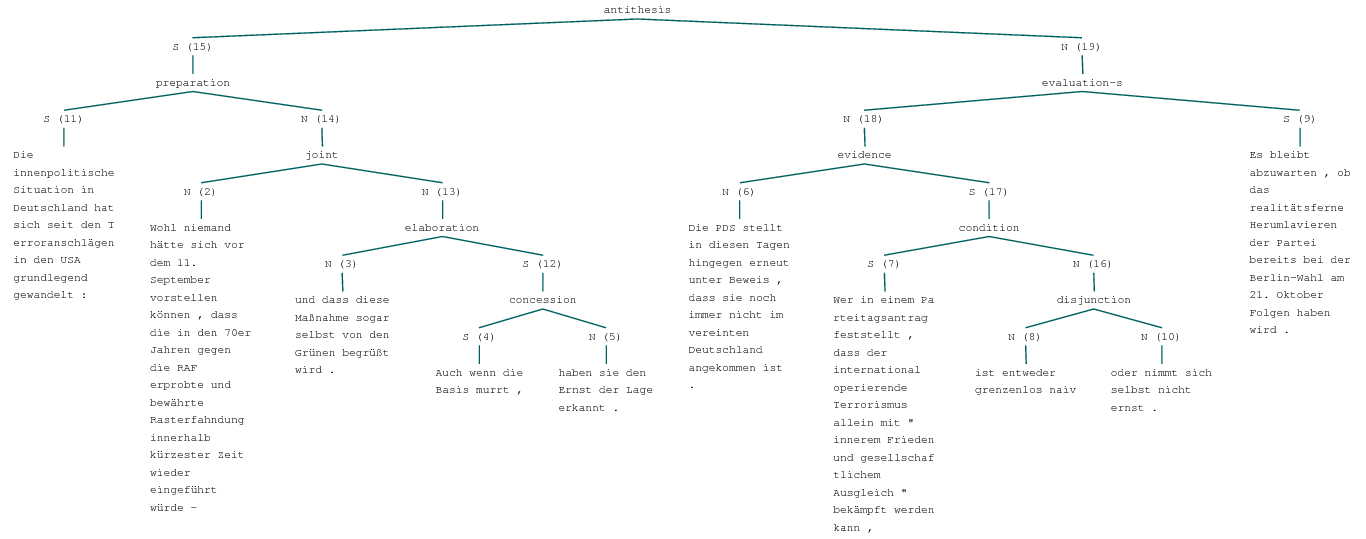

In [5]:
RSTTree(RS3_EXAMPLE_FILE, word_wrap=15)[1][0]

In [6]:
cdict, edict, ordered_edus = get_rs3_data(RS3_EXAMPLE_FILE)
edu_set = set(ordered_edus)

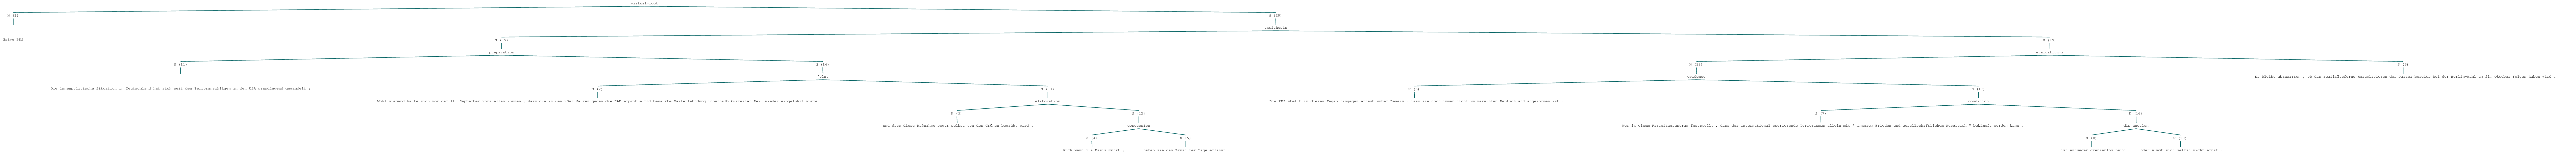

In [7]:
dt(cdict, edict, ordered_edus, start_node=None)

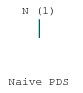

In [8]:
dt(cdict, edict, ordered_edus, start_node='1') # OK

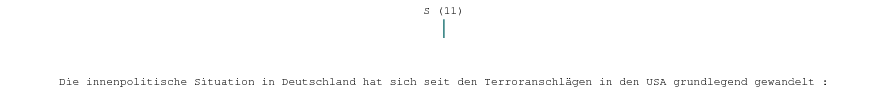

In [9]:
dt(cdict, edict, ordered_edus, start_node='11') # OK

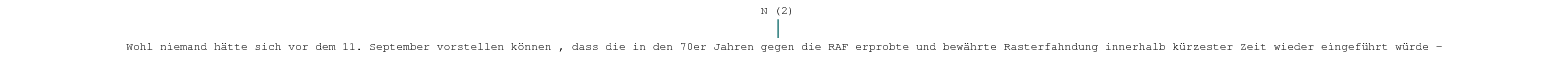

In [10]:
dt(cdict, edict, ordered_edus, start_node='2') # OK

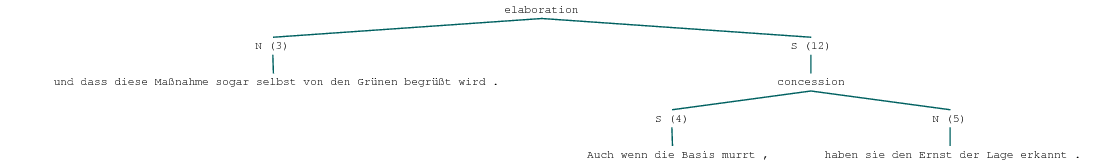

In [11]:
dt(cdict, edict, ordered_edus, start_node='3') # OK

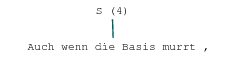

In [12]:
dt(cdict, edict, ordered_edus, start_node='4') # OK

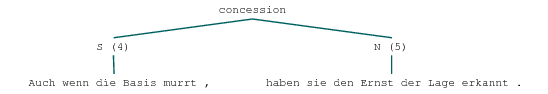

In [13]:
dt(cdict, edict, ordered_edus, start_node='5') # OK

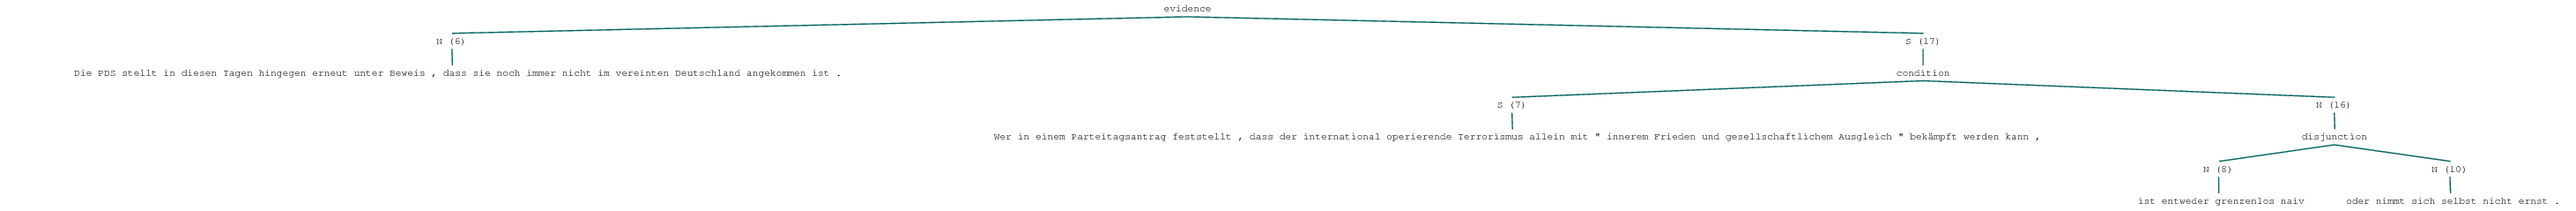

In [14]:
dt(cdict, edict, ordered_edus, start_node='6') # OK

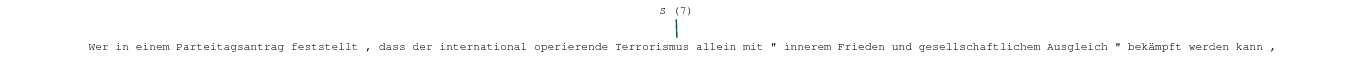

In [15]:
dt(cdict, edict, ordered_edus, start_node='7') # OK

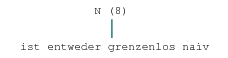

In [16]:
dt(cdict, edict, ordered_edus, start_node='8') # OK

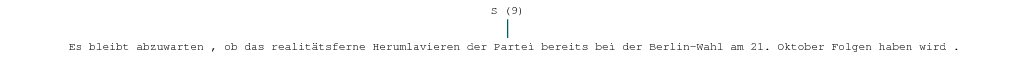

In [17]:
dt(cdict, edict, ordered_edus, start_node='9') # OK

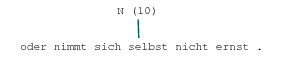

In [18]:
dt(cdict, edict, ordered_edus, start_node='10') # OK

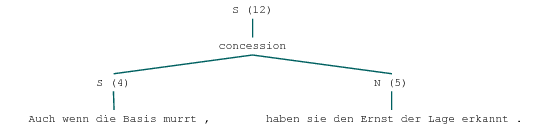

In [19]:
dt(cdict, edict, ordered_edus, start_node='12') # OK

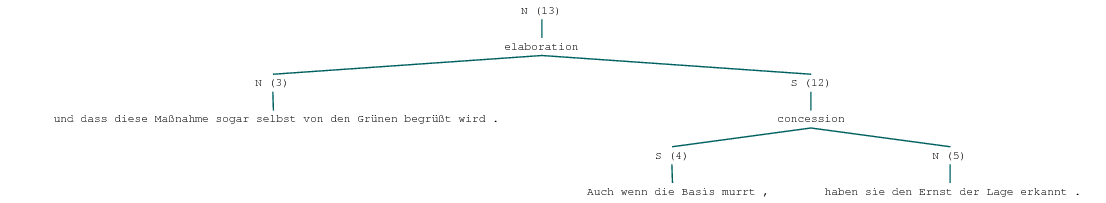

In [20]:
dt(cdict, edict, ordered_edus, start_node='13') # OK

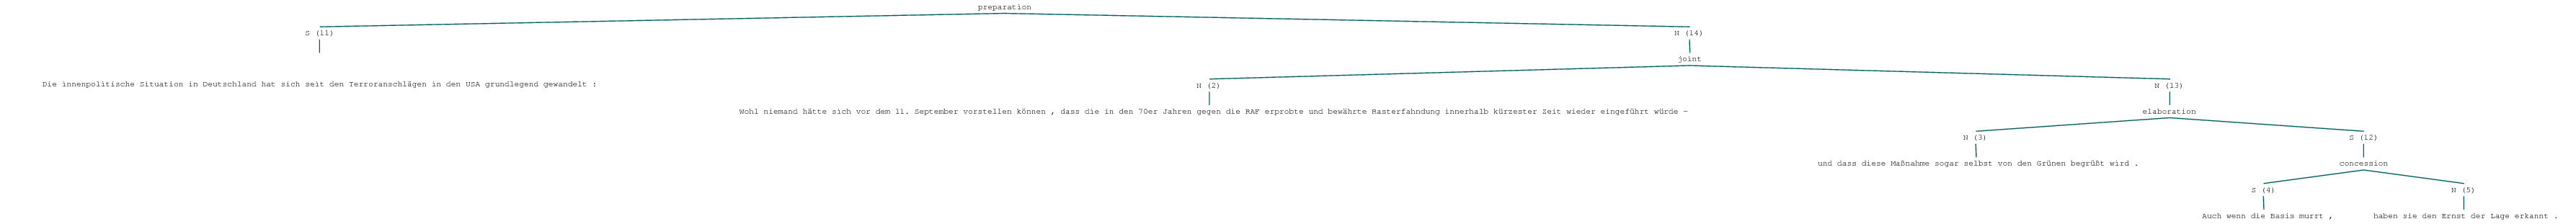

In [21]:
dt(cdict, edict, ordered_edus, start_node='14') # OK

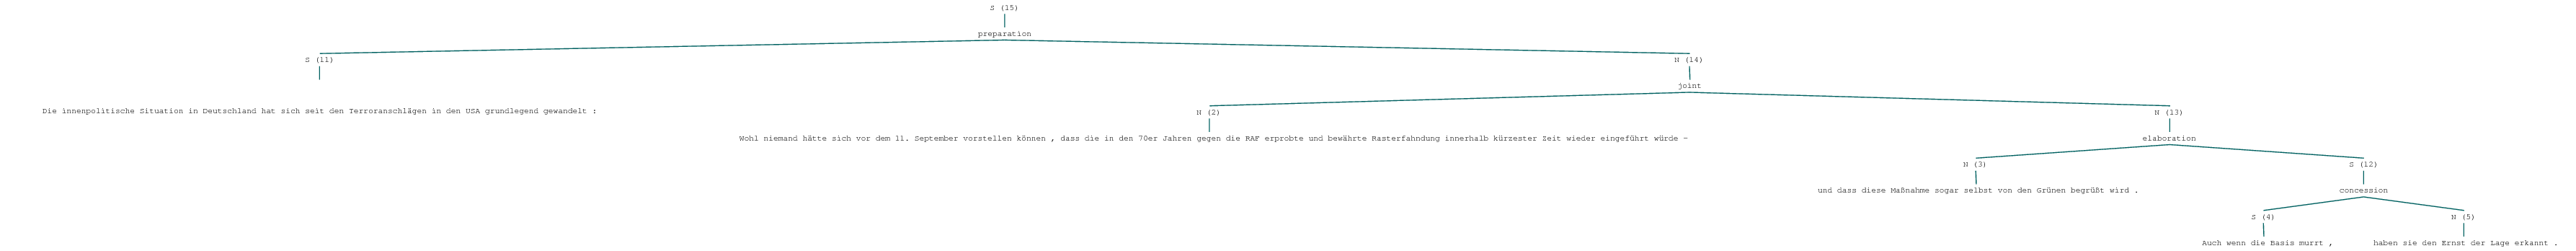

In [22]:
dt(cdict, edict, ordered_edus, start_node='15') # OK

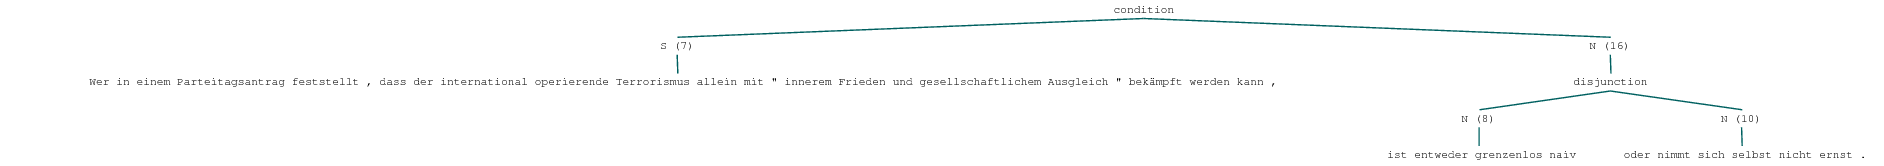

In [23]:
dt(cdict, edict, ordered_edus, start_node='16') # OK

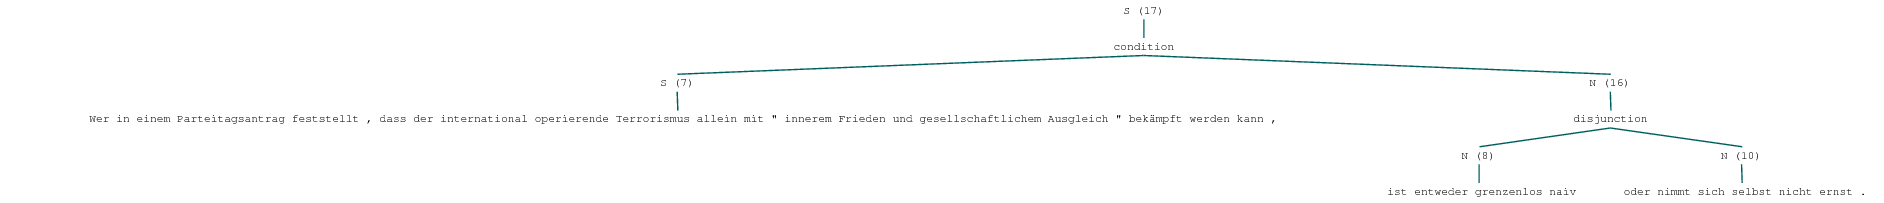

In [24]:
dt(cdict, edict, ordered_edus, start_node='17') # OK

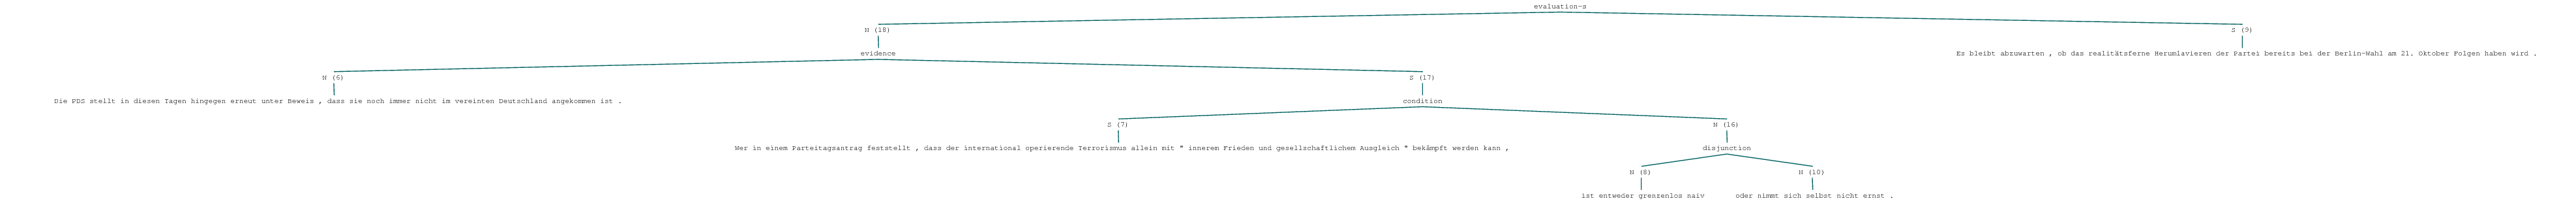

In [25]:
dt(cdict, edict, ordered_edus, start_node='18') # OK

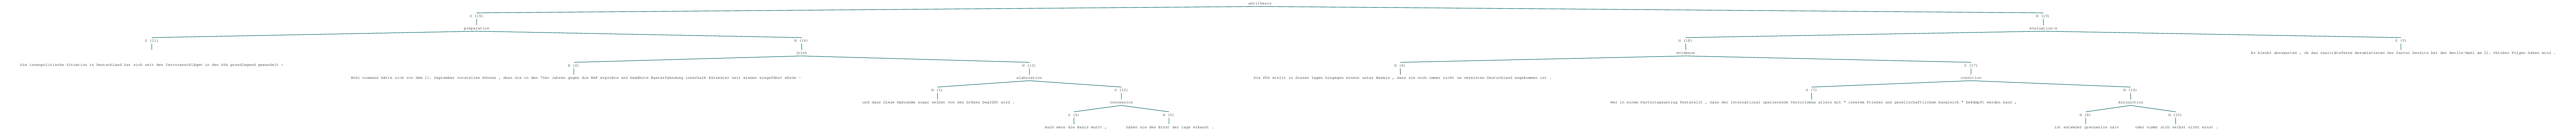

In [26]:
dt(cdict, edict, ordered_edus, start_node='19') # OK

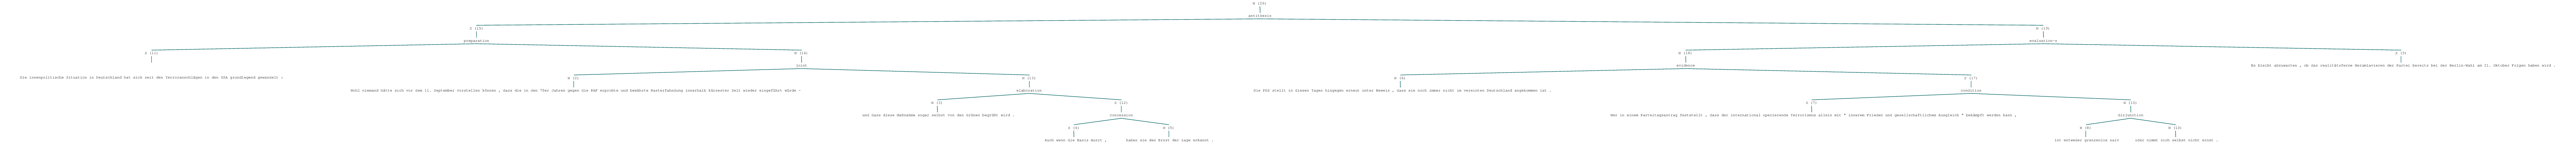

In [27]:
dt(cdict, edict, ordered_edus, start_node='20') # OK

# TODOs

## implement word-wrap
## only show node number in debug mode (otherwise: 'N' or 'S')

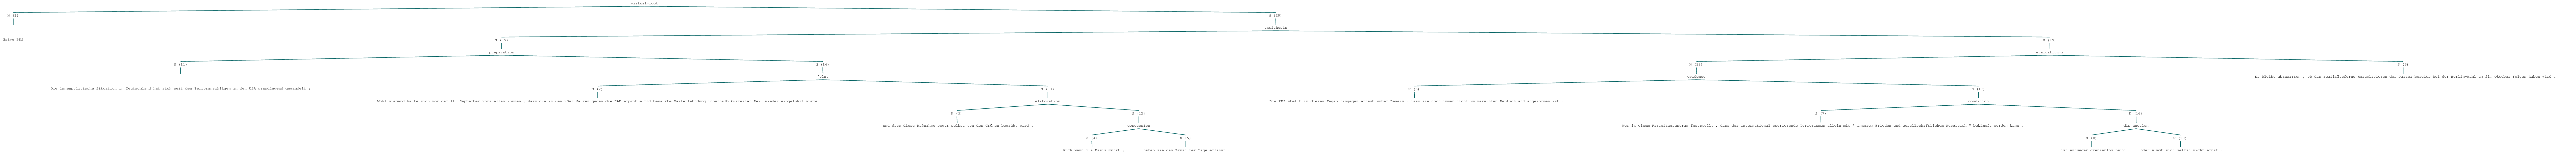

In [28]:
RSTTree(RS3_EXAMPLE_FILE)

# TODO: illegal trees for Manfred

In [56]:
maz_4031 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-4031.rs3'

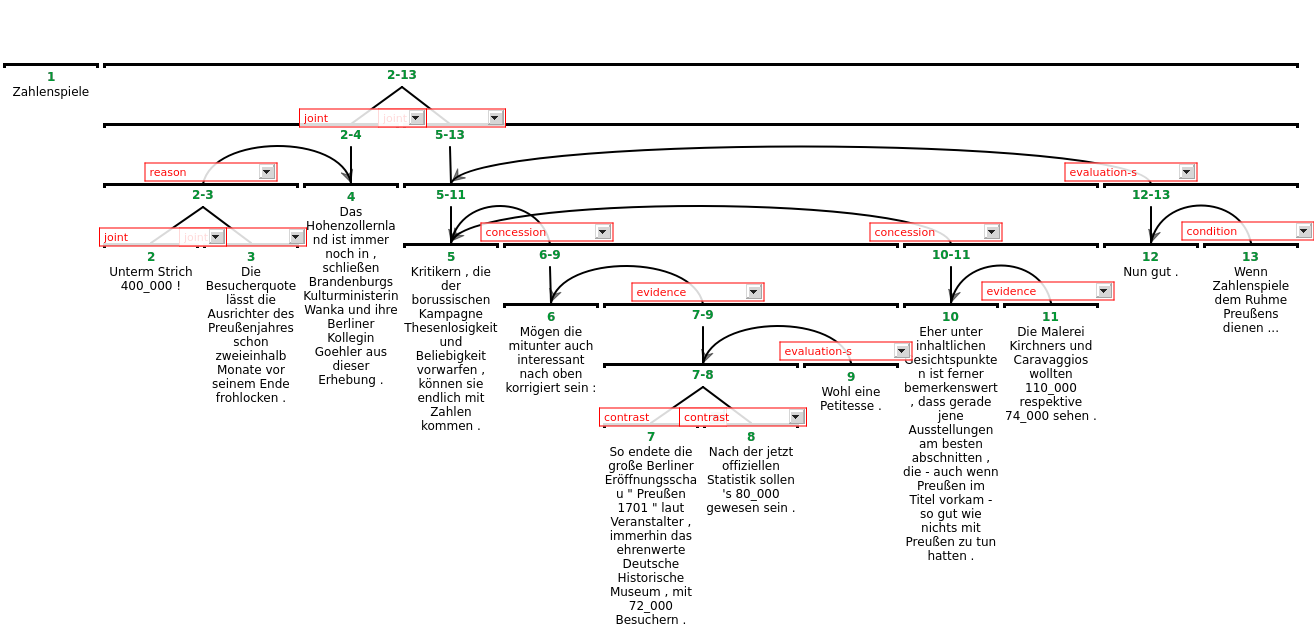

In [57]:
# TODO: show Manfred. Should be illegal: concession(6-9 -> 5) and concession(10-11 -> 5)!
embed_rs3_image(maz_4031)

In [31]:
# maz_6728 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-6728.rs3'

In [32]:
# TODO: show Manfred. Should be illegal: reason(6-8 -> 2-5) AND evidence(9-11 -> 2-5)
# embed_rs3_image(maz_6728)

In [33]:
maz_18377 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-18377.rs3'

In [34]:
# embed_rs3_image(maz_18377)

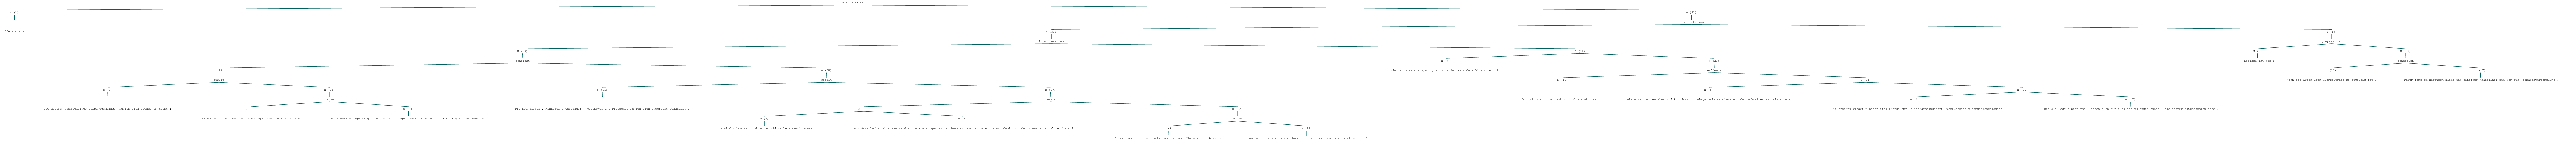

In [35]:
RSTTree(maz_18377)

In [36]:
maz_4031 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-4031.rs3'

In [55]:
# embed_rs3_image(maz_4031)

In [38]:
# AssertionError: A multinuc group (33) should not have > 1 non-multinuc children:
# ['26', '30', '32', '22', '36']
maz_2669 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-2669.rs3'

In [39]:
# embed_rs3_image(maz_2669)

In [40]:
# AssertionError: A multinuc group (19) should not have > 1 non-multinuc children: []
maz_14813 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-14813.rs3'

In [41]:
cdict, edict, ordered_edus = get_rs3_data(maz_14813, word_wrap=20)
edu_set = set(ordered_edus)

In [54]:
# embed_rs3_image(maz_14813)

In [43]:
# AssertionError: A multinuc group (19) should not have > 1 non-multinuc children: []
maz_7220 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-7220.rs3'

In [44]:
cdict, edict, ordered_edus = get_rs3_data(maz_7220, word_wrap=10)
edu_set = set(ordered_edus)

In [53]:
# embed_rs3_image(maz_7220)

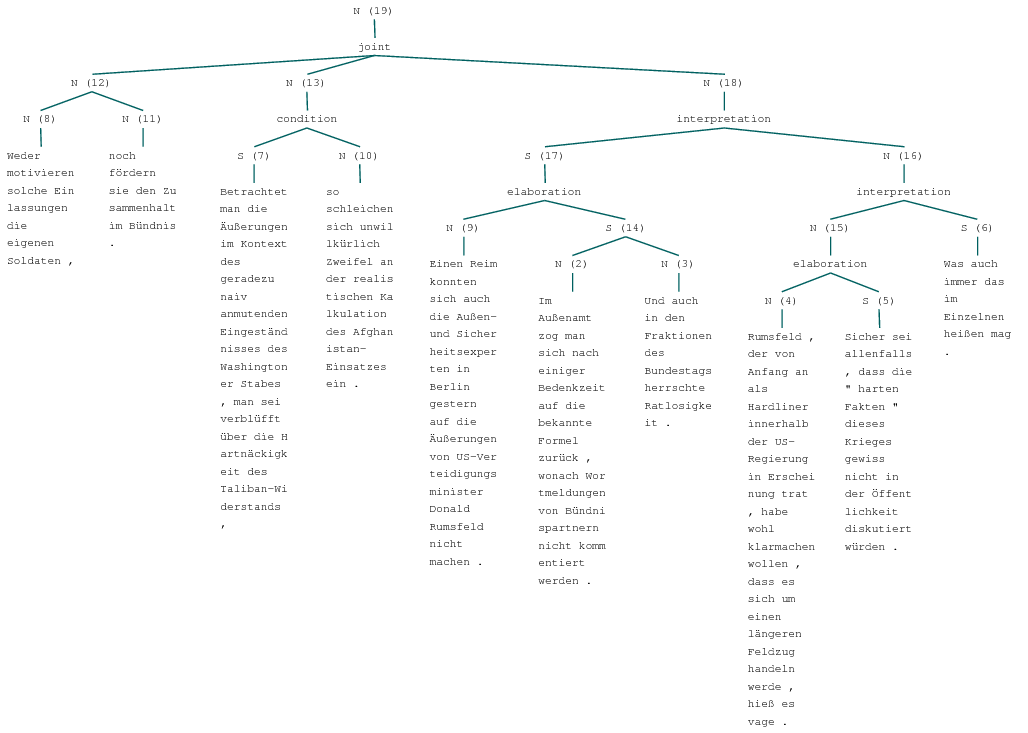

In [46]:
dt(cdict, edict, ordered_edus, start_node='19')

# TODO: maybe implement simple tree unification for URML first

# TODO: check all routines, that create t(foo, subtrees)

## assert that all subtrees are in the same relname/reltype with the tree

- if so --> t(foo, [(relname, subtrees)])

# TODO: add code for node with more than one non-multinuc children

## implement "relation stacking"

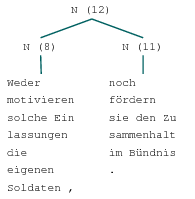

In [49]:
# FAIL: name of relation missing: conjunction(8, 11)
dt(cdict, edict, ordered_edus, start_node='12')

In [50]:
cdict['12']

['8', '11']

In [51]:
edict['12']

defaultdict(str,
            {'element_type': 'group',
             'group_type': 'multinuc',
             'nuclearity': 'nucleus',
             'parent': '19',
             'relname': 'joint',
             'reltype': 'multinuc'})

In [52]:
edict['8']

defaultdict(str,
            {'element_type': 'segment',
             'nuclearity': 'nucleus',
             'parent': '12',
             'relname': 'conjunction',
             'reltype': 'multinuc',
             'text': 'Weder\nmotivieren\nsolche Ein\nlassungen\ndie\neigenen\nSoldaten ,'})

In [47]:
import os
import traceback
from collections import Counter

from discoursegraphs.corpora import pcc

counter = Counter()
exceptions = Counter()
for rs3_file in pcc.rst:
    try:
        rt = RSTTree(rs3_file)
        counter["wins"] += 1
    except Exception as e:
        print rs3_file
        print("FAIL")
#         print traceback.format_exc()
        print e
        counter["fails"] += 1
#         exceptions[e.__class__.__name__] += 1
        exceptions[e] += 1
        print

/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-4031.rs3
FAIL
A span segment (5) should have one child: ['17', '20']

/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-6728.rs3
FAIL
A span group ('24') should not have > 2 children: ['10', '19', '23']

/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-16987.rs3
FAIL
A multinuc group (22) should not have > 1 non-multinuc children: ['6', '7']

/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-5873.rs3
FAIL
A span group ('25') should not have > 2 children: ['3', '19', '23']

/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-12666.rs3
F

In [48]:
print counter, "\n"
for e, count in exceptions.most_common():
    print e, count

Counter({'wins': 98, 'fails': 78}) 

A span group ('24') should not have > 2 children: ['10', '17', '21', '27'] 1
A multinuc group (28) should not have > 1 non-multinuc children: ['25', '30', '31'] 1
A span group ('19') should not have > 2 children: ['17', '18', '24'] 1
A span group ('28') should not have > 2 children: ['12', '27', '30'] 1
A span segment (10) should have one child: ['9', '11'] 1
A span segment (7) should have one child: ['22', '28'] 1
A span group ('23') should not have > 2 children: ['12', '24', '22'] 1
A multinuc segment (18) should not have children: ['40'] 1
A span group ('23') should not have > 2 children: ['4', '28', '30'] 1
A span group ('19') should not have > 2 children: ['11', '25', '30'] 1
A multinuc group (27) should not have > 1 non-multinuc children: ['10', '29'] 1
A multinuc group (25) should not have > 1 non-multinuc children: ['12', '20'] 1
A multinuc group (29) should not have > 1 non-multinuc children: ['8', '10'] 1
A span segment (6) should have one

# TODO: errors to look at

``AssertionError("A span segment (5) should have one child: ['17', '20']",)``
``AssertionError("A multinuc group (27) should not have > 1 non-multinuc children: ['5', '6', '7', '10', '28', '29']",)``

### bad annotation; show Manfred

``ValueError("A span group ('21') should not have > 2 children: ['4', '19', '20']",)``